In [169]:

import os
import re
import pandas as pd
import numpy as np
from collections import Counter
import nltk
nltk.download('punkt_tab')
  
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from github import Github

# Download NLTK resources if needed
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

class RepoDomainClassifier:
    def __init__(self, github_token=None):
        """
        Initialize the domain classifier.
        
        Args:
            github_token (str, optional): GitHub API token for higher rate limits.
        """
        self.github_token = github_token
        self.g = Github(github_token) if github_token else Github()
        
        # Define domain keywords
        self.domain_keywords = {
            'finance': ['finance', 'banking', 'investment', 'trading', 'stock', 'payment', 'currency', 'financial', 
                       'transaction', 'loan', 'credit', 'debit', 'accounting', 'money', 'wallet', 'crypto', 'blockchain'],
            'medical': ['health', 'medical', 'hospital', 'patient', 'doctor', 'healthcare', 'clinical', 'medicine', 
                       'diagnosis', 'treatment', 'disease', 'pharmacy', 'drug', 'biomedical', 'telemedicine'],
            'agriculture': ['farm', 'agriculture', 'crop', 'soil', 'harvest', 'livestock', 'plant', 'irrigation', 
                          'fertilizer', 'farming', 'agricultural', 'cultivation', 'agronomy'],
            'education': ['education', 'school', 'learning', 'student', 'teacher', 'course', 'academic', 'classroom', 
                         'curriculum', 'lesson', 'teaching', 'e-learning', 'educational', 'study', 'training'],
            'gaming': ['game', 'gaming', 'player', 'multiplayer', 'score', 'gameplay', 'unity', 'unreal', 'console', 
                      'playable', 'level', 'character', 'interactive', 'arcade', 'simulation'],
            'technology': ['tech', 'software', 'hardware', 'computer', 'network', 'server', 'database', 'cloud', 
                          'program', 'technology', 'system', 'application', 'interface', 'development', 'code'],
            'ecommerce': ['ecommerce', 'shopping', 'store', 'product', 'retail', 'checkout', 'cart', 'order', 
                         'inventory', 'merchant', 'customer', 'sale', 'purchase', 'marketplace'],
            'transportation': ['transport', 'vehicle', 'car', 'bus', 'train', 'flight', 'travel', 'navigation', 
                             'gps', 'map', 'route', 'logistics', 'shipping', 'delivery'],
            'entertainment': ['media', 'video', 'audio', 'music', 'stream', 'entertainment', 'movie', 'show', 
                            'podcast', 'play', 'watch', 'listen', 'broadcast'],
            'social': ['social', 'network', 'community', 'friend', 'message', 'chat', 'profile', 'user', 
                      'connection', 'like', 'share', 'follow', 'communication']
        }
        
        # Create a model (simple keyword-based for this script)
        self.stop_words = set(stopwords.words('english'))
        
    def clean_text(self, text):
        """Clean and tokenize text."""
        if not isinstance(text, str):
            return []
        
        # Remove code snippets, URLs, and special characters
        text = re.sub(r'```.*?```', ' ', text, flags=re.DOTALL)
        text = re.sub(r'http\S+', ' ', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Tokenize and remove stopwords
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in self.stop_words and len(word) > 2]
        
        return tokens
    
    def analyze_repo(self, repo_url):
        """
        Analyze a GitHub repository to determine its domain.
        
        Args:
            repo_url (str): URL of the GitHub repository
            
        Returns:
            dict: Domain classification with confidence scores
        """
        # Extract owner and repo name from URL
        pattern = r'github\.com\/([^\/]+)\/([^\/]+)'
        match = re.search(pattern, repo_url)
        
        if not match:
            return {"error": "Invalid GitHub URL"}
        
        try:
            owner, repo_name = match.groups()
            repo = self.g.get_repo(f"{owner}/{repo_name}")
            
            # Collect text from README, description, and other important files
            all_content = []
            
            # Add repo description
            if repo.description:
                all_content.append(repo.description)
            
            # Add README content
            try:
                readme = repo.get_readme()
                readme_content = readme.decoded_content.decode('utf-8')
                all_content.append(readme_content)
            except:
                pass
            
            # Get top-level files and directories
            contents = repo.get_contents("")
            important_files = []
            
            for content in contents:
                if content.type == "file" and content.name.lower() in [
                    'package.json', 'requirements.txt', 'setup.py', 'pom.xml', 
                    'gemfile', 'build.gradle', 'cargo.toml', 'pubspec.yaml'
                ]:
                    important_files.append(content)
            
            # Add content from important files
            for file in important_files:
                try:
                    file_content = file.decoded_content.decode('utf-8')
                    all_content.append(file_content)
                except:
                    pass
            
            # Analyze repo content
            return self._classify_text(" ".join(all_content))
            
        except Exception as e:
            return {"error": str(e)}
            
    def analyze_local_repo(self, folder_path):
        """
        Analyze a local repository folder to determine its domain.
        
        Args:
            folder_path (str): Path to the local repository folder
            
        Returns:
            dict: Domain classification with confidence scores
        """
        try:
            # Collect text from README, description, and other important files
            all_content = []
            
            # Check if the folder exists
            if not os.path.isdir(folder_path):
                return {"error": f"Folder not found: {folder_path}"}
            
            # Look for README files
            readme_patterns = ['README.md', 'README.txt', 'readme.md', 'readme.txt', 'README', 'readme']
            for pattern in readme_patterns:
                readme_path = os.path.join(folder_path, pattern)
                if os.path.exists(readme_path):
                    try:
                        with open(readme_path, 'r', encoding='utf-8', errors='ignore') as f:
                            readme_content = f.read()
                            all_content.append(readme_content)
                    except:
                        pass
                    break
            
            # Look for important files
            important_file_names = [
                'package.json', 'requirements.txt', 'setup.py', 'pom.xml', 
                'Gemfile', 'build.gradle', 'Cargo.toml', 'pubspec.yaml',
                'DESCRIPTION', 'description.md', 'ABOUT.md', 'about.md'
            ]
            
            for filename in important_file_names:
                file_path = os.path.join(folder_path, filename)
                if os.path.exists(file_path):
                    try:
                        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                            file_content = f.read()
                            all_content.append(file_content)
                    except:
                        pass
            
            # If we don't have enough content, look for more text files
            if len("".join(all_content)) < 500:
                for root, dirs, files in os.walk(folder_path):
                    # Skip .git directory
                    if '.git' in dirs:
                        dirs.remove('.git')
                    
                    # Skip node_modules directory
                    if 'node_modules' in dirs:
                        dirs.remove('node_modules')
                    
                    # Limit depth to avoid too many files
                    if root.count(os.sep) - folder_path.count(os.sep) > 2:
                        continue
                    
                    for file in files:
                        if file.lower().endswith(('.md', '.txt', '.rst', '.py', '.js', '.java', '.html')):
                            file_path = os.path.join(root, file)
                            try:
                                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                                    # Read only the first 1000 chars of each file to avoid huge files
                                    file_content = f.read(1000)
                                    all_content.append(file_content)
                            except:
                                pass
                            
                            # Limit to 10 additional files
                            if len(all_content) > 10:
                                break
            
            # Analyze repo content
            if not all_content:
                return {"error": "No readable content found in repository"}
                
            return self._classify_text(" ".join(all_content))
            
        except Exception as e:
            return {"error": str(e)}
    
    def _classify_text(self, text):
        """Classify text into domains based on keyword frequency."""
        tokens = self.clean_text(text)
        word_counts = Counter(tokens)
        
        # Calculate domain scores
        domain_scores = {}
        total_matched_keywords = 0
        
        for domain, keywords in self.domain_keywords.items():
            score = sum(word_counts.get(keyword, 0) for keyword in keywords)
            domain_scores[domain] = score
            total_matched_keywords += score
        
        # Calculate percentages
        if total_matched_keywords > 0:
            domain_percentages = {domain: (score / total_matched_keywords) * 100 
                                 for domain, score in domain_scores.items()}
        else:
            domain_percentages = {domain: 0 for domain in self.domain_keywords.keys()}
        
        # Sort domains by score
        sorted_domains = sorted(domain_percentages.items(), key=lambda x: x[1], reverse=True)
        
        # Determine primary and secondary domains
        result = {
            "primary_domain": sorted_domains[0][0] if sorted_domains[0][1] > 0 else "unknown",
            "confidence": sorted_domains[0][1],
            "all_domains": {domain: round(score, 2) for domain, score in sorted_domains if score > 0}
        }
        
        return result

def analyze_multiple_repos():
    """Function to analyze multiple repositories from a folder"""
    
    # Initialize classifier
    classifier = RepoDomainClassifier()
    
    # Create a DataFrame to store results
    results_df = pd.DataFrame(columns=["repo_id", "primary_domain", "confidence", "all_domains"])
    
    # Loop through repositories
    for x in range(1, 71):
        print(f"FOR REPO - {x}")
        folder_path = f'C:\\Users\\apoor\\cloned 70 repos\\repo_{x}'
        
        # Check if folder exists
        if not os.path.exists(folder_path):
            print(f"  Folder not found: {folder_path}")
            continue
        
        # Analyze repository
        result = classifier.analyze_local_repo(folder_path)
        
        if "error" in result:
            print(f"  Error: {result['error']}")
            continue
        
        # Print results
        print(f"  Primary Domain: {result['primary_domain']} (Confidence: {result['confidence']:.2f}%)")
        print("  All Detected Domains:")
        for domain, score in result['all_domains'].items():
            print(f"  - {domain}: {score:.2f}%")
        
        # Add to DataFrame
        results_df = results_df._append({
            "repo_id": x,
            "primary_domain": result['primary_domain'],
            "confidence": result['confidence'],
            "all_domains": result['all_domains']
        }, ignore_index=True)
    
if __name__ == "__main__":
    analyze_multiple_repos()


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\apoor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
C:\Users\apoor\AppData\Local\Temp\ipykernel_19808\502870391.py:285: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = results_df._append({


FOR REPO - 1
  Primary Domain: technology (Confidence: 44.44%)
  All Detected Domains:
  - technology: 44.44%
  - social: 22.22%
  - ecommerce: 11.11%
  - transportation: 11.11%
  - entertainment: 11.11%
FOR REPO - 2
  Primary Domain: technology (Confidence: 47.84%)
  All Detected Domains:
  - technology: 47.84%
  - social: 45.32%
  - entertainment: 2.52%
  - ecommerce: 1.80%
  - gaming: 1.08%
  - transportation: 0.72%
  - finance: 0.36%
  - medical: 0.36%
FOR REPO - 3
  Primary Domain: technology (Confidence: 30.00%)
  All Detected Domains:
  - technology: 30.00%
  - social: 30.00%
  - entertainment: 20.00%
  - gaming: 10.00%
  - ecommerce: 10.00%
FOR REPO - 4
  Primary Domain: technology (Confidence: 68.57%)
  All Detected Domains:
  - technology: 68.57%
  - social: 17.14%
  - entertainment: 11.43%
  - ecommerce: 2.86%
FOR REPO - 5
  Primary Domain: social (Confidence: 74.26%)
  All Detected Domains:
  - social: 74.26%
  - technology: 22.79%
  - ecommerce: 1.47%
  - entertainment: 1.

In [171]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import mixedlm
import numpy as np

df = pd.read_csv("Desktop/final_dataset_domain.csv")
print("Shape of the DataFrame:", df.shape)
print("Missing values in each column:")
print(df.isnull().sum())
df = df.dropna(subset=['testloc_beforeci', 'commits_before_CI', 'testloc_afterci', 'commits_after_CI', 
                       'size_mb', 'closed_prs', 'open_prs', 'language', 'total_committers', 
                       'test_changes_per_commit', 'commits_for_test','test_LOC','total_LOC','total_duration','travis_duration_days' ])
df = df.reset_index(drop=True)
print(df.head())

Shape of the DataFrame: (70, 27)
Missing values in each column:
repo_name                  0
stars                      0
issues                     0
open_prs                   0
closed_prs                 0
total_prs                  0
language                   0
is_fork                    0
url                        0
size_mb                    0
uses_travis                0
travis_start_date          0
travis_end_date            0
travis_duration_days       0
total_LOC                  0
test_LOC                   0
commits_before_CI          0
commits_after_CI           0
total_committers           0
test_changes_per_commit    0
commits_for_test           0
project_start_date         0
project_end_date           0
total_duration             0
testloc_beforeci           0
testloc_afterci            0
domain                     0
dtype: int64
                        repo_name  stars  issues  open_prs  closed_prs  \
0                   alibaba/nacos  30811     242        13        

In [193]:
#MODEL 1 - Before CI

df['commitbasedtestratio_beforeci'] = df['testloc_beforeci'] / df['commits_before_CI']
formula_before_ci = 'commitbasedtestratio_beforeci ~ size_mb + closed_prs + open_prs + language + total_committers + test_changes_per_commit + commits_for_test + domain'

model_before_ci = mixedlm(formula_before_ci, df, groups=df['domain'],re_formula="1")
result_before_ci = model_before_ci.fit()

#MODEL 2 - After CI

df['commitbasedtestratio_afterci'] = df['testloc_afterci'] / df['commits_after_CI']
formula_after_ci = 'commitbasedtestratio_afterci ~ size_mb + closed_prs + open_prs + language + total_committers + test_changes_per_commit + commits_for_test + domain'

model_after_ci = mixedlm(formula_after_ci, df, groups=df['domain'],re_formula="1")
result_after_ci = model_after_ci.fit()

print("\nAfter CI Model Summary:")
print(result_after_ci.summary())




After CI Model Summary:
                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: commitbasedtestratio_afterci
No. Observations: 70      Method:             REML                        
No. Groups:       10      Scale:              6188.9633                   
Min. group size:  1       Log-Likelihood:     -329.6200                   
Max. group size:  44      Converged:          Yes                         
Mean group size:  7.0                                                     
--------------------------------------------------------------------------
                            Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------------
Intercept                    52.347  123.556  0.424 0.672 -189.818 294.512
language[T.C++]              10.220   30.420  0.336 0.737  -49.402  69.842
language[T.Java]             26.504   28.622  0.926 0.354  -29.594  82.601
language[T.JavaScri

C:\Users\apoor\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:508: RuntimeWarning: invalid value encountered in subtract
  return rhs / s - ql / s**2
C:\Users\apoor\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\apoor\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\apoor\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users\apoor\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\apoor

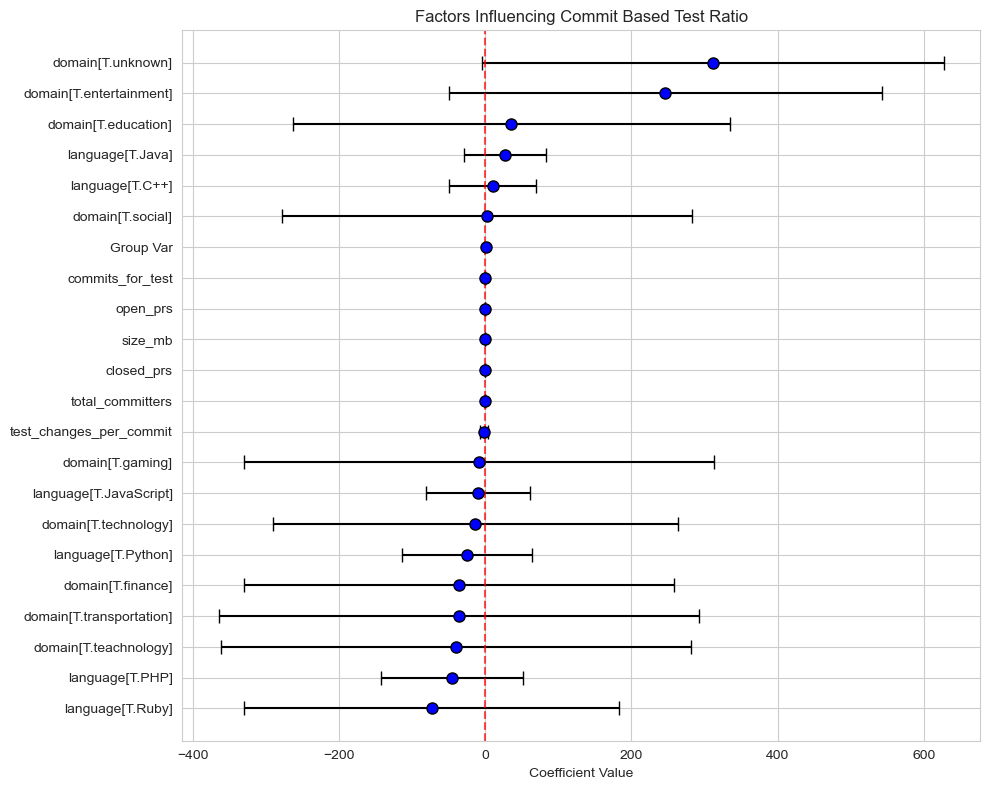

Most Important Factor came out to be 'PROJECT INHERENT FACTOR - DOMAIN'


In [195]:
#Plotting 
params = result_after_ci.params[1:]  
conf_int = result_after_ci.conf_int().iloc[1:] 
coef_names = params.index

plot_df = pd.DataFrame({
    'coef': params,
    'lower': conf_int[0],
    'upper': conf_int[1],
    'name': coef_names
})

plot_df = plot_df.sort_values('coef')
plt.figure(figsize=(10, 8))
sns.set_style('whitegrid')

plt.errorbar(
    plot_df['coef'], 
    np.arange(len(plot_df)), 
    xerr=np.array([plot_df['coef'] - plot_df['lower'], plot_df['upper'] - plot_df['coef']]),
    fmt='o', 
    capsize=5, 
    ecolor='black', 
    markersize=8, 
    markerfacecolor='blue',
    markeredgecolor='black'
)

plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.yticks(np.arange(len(plot_df)), plot_df['name'])

plt.xlabel('Coefficient Value')
plt.title('Factors Influencing Commit Based Test Ratio')
plt.tight_layout()
plt.show()
print("Most Important Factor came out to be 'PROJECT INHERENT FACTOR - DOMAIN'")